In [1]:
import pandas as pd
import ast
import statistics
import matplotlib.pyplot as plt
import numpy as np
import numpy
import tables
from scipy.stats import spearmanr
from nltk.corpus import cmudict
import nltk.corpus.reader.cmudict
from string import digits
import json
from nltk.tokenize import RegexpTokenizer

In [2]:
def iterate_data(h5_file):
    for x in h5_file.root:
        yield x
def create_word_distribution(path):
    df = pd.read_csv(path)
    df["Testedword"] = df["Tested"].str.replace("flickr_","")
    df["Testedword"] = [words.split("_")[0] for words in df["Testedword"]]
    df["Results"] = [ast.literal_eval(score) for score in df["Results"]]
    df["Precision@10"] = [sum(score)*0.1 for score in df["Results"]]

    #words tested
    testlist = ["dog","man","boy","girl","woman","people"
                ,"dogs","shirt","child","ball","person"
                ,"children","men","girls","bike","rock","camera"
                ,"boys","hat","player","jacket","basketball","swing"
                ,"car", "wall", "hair","football","sunglasses","head"
                ,"shorts","dress","table","water","grass","bench","snow"
                ,"air","field","street","mouth","dirt","mountain","pool"
                ,"ocean","sand","building","soccer","park","face"]

    scorelist = pd.DataFrame()

    for word in testlist:
        dflength = len(df[df["Testedword"] == word]["Precision@10"])
        averagescore = df[df["Testedword"] == word]["Precision@10"].sum()/dflength
        stdev = statistics.stdev(list(df[df["Testedword"] == word]["Precision@10"]))

        valuesdict = {"Word": word, "AvgScore": averagescore, "Stdev": stdev}
        scorelist = scorelist.append(valuesdict, ignore_index=True)

    num_bins = 1

    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(scorelist["AvgScore"], bins = numpy.arange(0, 1.1, 0.1),color="#083370") 
    plt.xticks(numpy.arange(0, 1.1, step=0.1))
    ax.set_xlabel('Precision@10')
    ax.set_ylabel('Number of Words')
    ax.set_title(f"Distribution of Average Precision@10 \n scores")
    plt.rc('axes', titlesize=15) 
    plt.rc('axes', labelsize=15)
    plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=12)
    plt.tight_layout()
    plt.savefig('../plots/precision@10testedobjects.png',dpi=1200)

    plt.show()

    plt.style.use('seaborn-deep')

    num_bins = 10
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(scorelist["Stdev"], bins = numpy.arange(0, 0.4, 0.02),color="#083370") 
    plt.xticks(numpy.arange(0, 0.4, step=0.05))
    ax.set_xlabel('Standard Deviation')
    ax.set_ylabel('Amount of Words')
    ax.set_title(f"Distribution of Precision@10 \n Standard Deviation scores for the {len(scorelist)} tested words")

    # plt.savefig('/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/plots/stdevtestedobjects.png')

    plt.show()
    return scorelist
 

In [3]:
pathprimes = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/priming/results_primes.csv"
pathtargets = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/priming/results_targets.csv"
pathrandomprimes = "/Users/sebastiaanscholten/Documents/speech2image-master/vgsexperiments/experiments/priming/results_primes_random.csv"

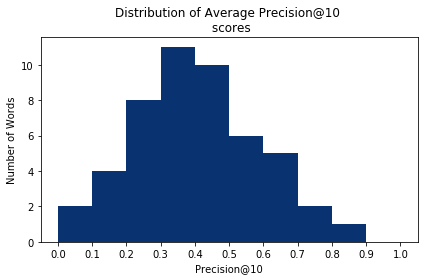

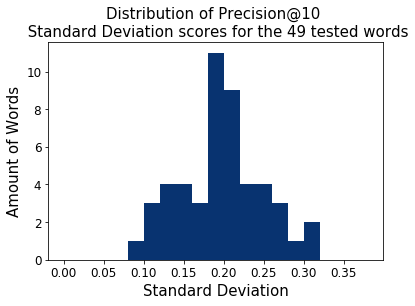

In [4]:
primescores = create_word_distribution(pathprimes)

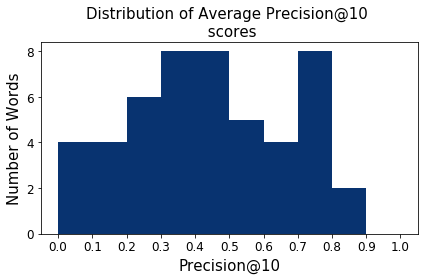

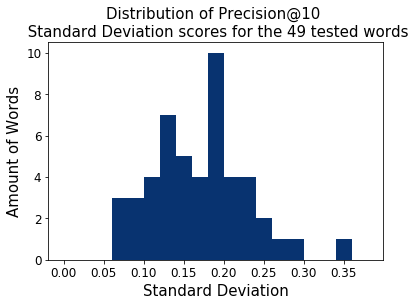

In [5]:
targetscores = create_word_distribution(pathtargets)

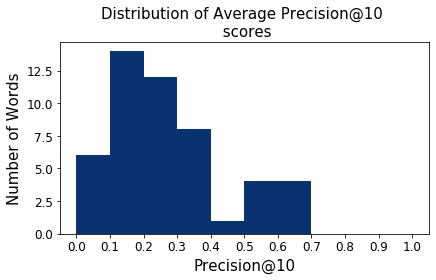

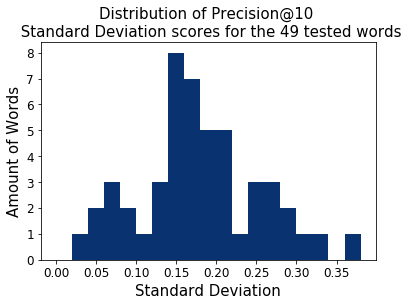

In [6]:
randomprimescores = create_word_distribution(pathrandomprimes)

In [7]:
targetscores["Primescores"] = primescores["AvgScore"]
targetscores["randomPrimescores"] = randomprimescores["AvgScore"]
targetscores = targetscores.sort_values(["AvgScore"],ascending=False)


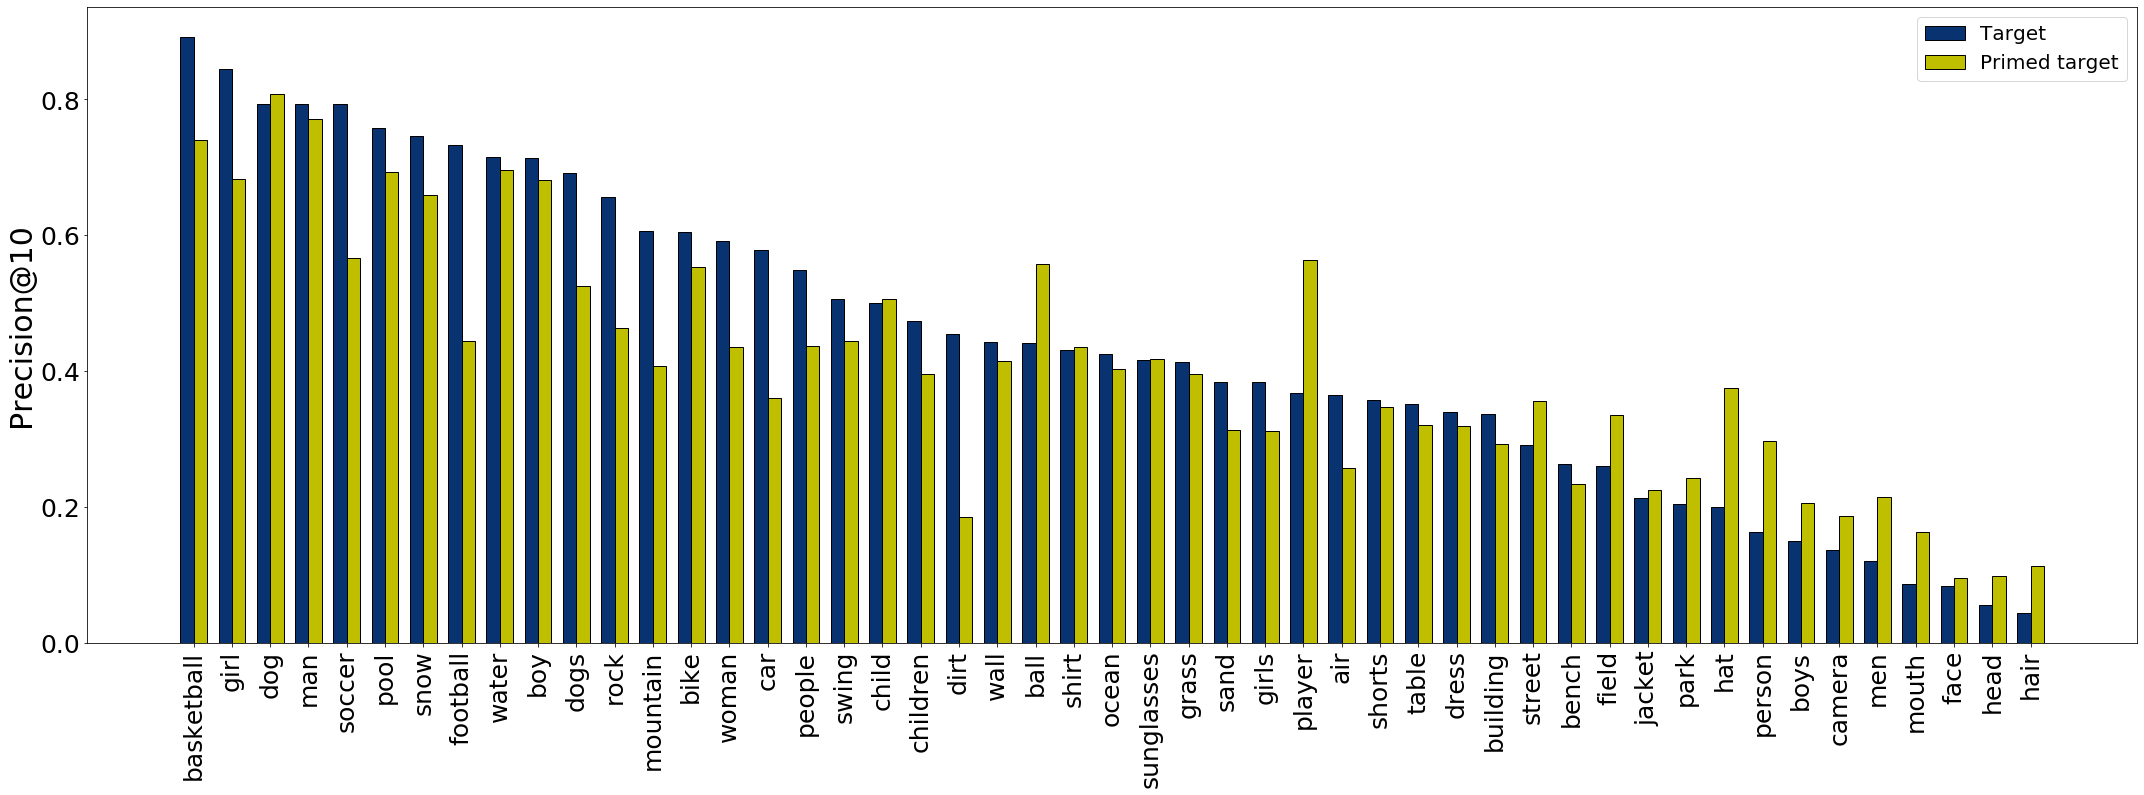

In [15]:
fig, ax = plt.subplots(figsize=(30, 10))
barWidth = 0.35
r1 = np.arange(len(targetscores["Word"]))+barWidth/2
r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]

plt.style.use('seaborn-deep')

plt.rcParams.update({'font.size': 20}) 

plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)

plt.tight_layout()
ax.bar(r1, targetscores["AvgScore"], width=barWidth, color='#083370',edgecolor="black", align='center',label="Target")
ax.bar(r2, targetscores["Primescores"], width=barWidth, color='y', edgecolor="black",align='center',label="Primed target")
# ax.bar(r3, targetscores["randomPrimescores"], width=barWidth, color='#b4c1d4', edgecolor="black",align='center',label="Randomly primed target")

plt.xticks([r + barWidth for r in range(len(targetscores["Word"]))], targetscores["Word"])
plt.xticks(rotation=90)
ax.set_ylabel('Precision@10',fontsize=30)
ax.set_title(f"",fontsize=30)

plt.legend()
plt.savefig("primes.jpg")
plt.show()

In [53]:
import math
percentagelist = []
percentagelistbottom50 = []
for target,primed in zip(targetscores["AvgScore"],targetscores["Primescores"]):
    percentagelist.append(100 * (primed - target) / target)

targetscoresbottom50 = targetscores[math.floor(len(targetscores)/2):]
for target,primed in zip(targetscoresbottom50["AvgScore"],targetscoresbottom50["Primescores"]):
    percentagelistbottom50.append(100 * (primed - target) / target)
    
averagepercentagechange = sum(percentagelist)/len(percentagelist)
bottom50percentagechange = sum(percentagelistbottom50)/len(percentagelistbottom50)
print(f"Percentage change all: {math.ceil(averagepercentagechange)}%")
print(f"Percentage change bottom 50%: {math.ceil(bottom50percentagechange)}%")

Percentage change all: 6%
Percentage change bottom 50%: 27%


In [76]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(targetscores["AvgScore"], targetscores["Primescores"])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=402.000, p=0.036
Different distributions (reject H0)


In [72]:
from numpy import mean
from numpy import std

print('data1: mean=%.3f stdv=%.3f' % (mean(targetscores["AvgScore"]), std(targetscores["AvgScore"])))
print('data2: mean=%.3f stdv=%.3f' % (mean(targetscores["Primescores"]), std(targetscores["Primescores"])))

data1: mean=0.443 stdv=0.231
data2: mean=0.407 stdv=0.181
